# Forest Fires Analysis
Author: Simon Thornewill von Essen

Date: 2019-05-24

Forest fires are dangerous to human and animal lives and can cause lots of expensive damage to homes and buildings. As such, it is important firefighting is done efficiently in order to minimise costs. Towards this end, being able to predict forest fires can help with reaction time which can make fires easier to handle. This is especially germane due to global warming increasing the frequency and severity of forest fires.[[1]](https://www.c2es.org/content/wildfires-and-climate-change/) 

Some preliminary work has been done by Cortez *Et. Al.* to collect some data using relatively cheap sensors and to create a supervised learning model to regress on the total area burned by each fire. They used an SVM in order to achieve this. With a best MAD value of $12.71 \pm 0.01$ while predicting smaller fires more accurately.

I want to try and explore this dataset a little bit and see if I can create a better model using XG-Boost based on some machine learning my colleagues are performing at work on a variable with a similar distribution. 

## Importing Packages, Data and Comprehension

Before doing any serious anyalysis, the data will be imported and some basic discussion over the features in the dataset will be done. 

In [5]:
# Import the holy trinity, long may they live
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Import the rest...
from pprint import pprint



# Acquire a sense of taste
plt.style.use("seaborn")

In [2]:
# Import dataset
df = pd.read_csv("../dat/forestfires.csv")

df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
# Identify shape of dataset
df.shape

(517, 13)

In this dataset we have 517 observations, 12 explanatory variables (features) and one target variable, the area.

The variables are as follows;

1. X - x-axis spatial coord for Monteshino Park
2. Y - y-axis spatial coord for M. Park
3. month - month of the year
4. day - day of the week
5. FFMC - Fine Fuel Moisture Code index of FWI system
6. DMC - Duff Moisture Code index of FWI system 
7. DC - Drought Code index of the FWI system
8. ISI - Buildup Index of the FWI system
9. temp - temperature in $C^\circ$
10. RH - relative humidity in $\%$
11. wind - wind speed in $km/h$
12. rain - rainfall in $mm/m^2$

The target variable, fire area, is measured in $ha$.

### The Canadian Forest Fire Weather Index (FWI) System

This dataset makes use of the Canadian Forest Fire Weather Index (FWI) system. [[2]](http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi) These metrics are calculated using the temp., wind, humidity and rain features of the dataset, as seen in the image below.

![FWI System](./fwi_structure.gif)

This means that although we have 13 features, we probably shouldn't use all features at once, since certain features will be able to be found within each other. This means that we should investigate which features are better predictors of our target variable. For example. Is it better to use simple Wind or Initial Spread Index? Is it better to use a combination of temp. humidity and rain or simply the duff moisture code?

### Plan of Attack and Initial Questions

First I would like to at least skim the paper associated with this dataset to try and understand the approach of Cortez *Et. Al.*. It would also be a good idea to try and implement their solution and try to achieve similar results before going on to writing my own algorithm.

Before doing any modeling however, I would also like check the data for cleanliness and tidiness before doing some EDA using visualisations. 

Finally, one of the major drawbacks of this dataset is the lack of features. Unfortunately, this means that there is a limited scope for feature engineering, which is typically responsible for the greatest increases in scores for supervised learning. However, I might be able to use the X, Y variables to create some kind of categorical variable to be used for the regression.

Leading Questions:
1. What variable has the highest correlation with burn area?
2. Can I build a model that is better than what is described in this paper?
3. Can I use the X, Y coordinates of this dataset to engineer a new variable?

### Notes After Reading Paper

The notes can be found in the `research` directory of this project. The basic gist of it is to use `c-to-1` encoding for the nominal categorical features and to normalise the rest of the featues on $N(0, 1)$. I should then fit the SVM using grid-search and 10-fold cross validation. I didn't understand anything more specific than that. So this will be my reference model for this analysis.

There was a little bit of feature engineering beyond the basic clearning that went into the dataset that I downloaded, but I didn't quite understand what they were doing and so I won't attempt much more than what I attempt to do on my own.

This means that my model may not be as performant as the one found in the paper.

## EDA: Univariate Analysis

First, we want to do a univariage analysis of the data. This means that we check the distributions and some descriptive statistics for each one as necessary. 

In [9]:
df.columns.tolist()

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area']

Let's have a look at our features in the following order:
1. Target Variable - `area`
2. Location - `X`, `Y`
3. Time - `Month`, `Day`
4. FWI Vars - `FFMC`, `DMC`, `DC`, `ISI`
5. Meterological Data - `temp`, `RH`, `wind`, `rain`

First up, the area.

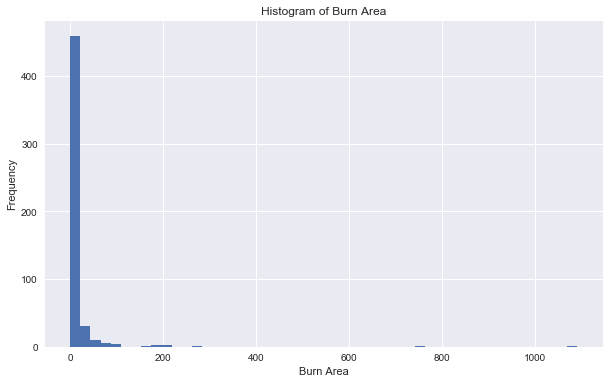

In [27]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(df.area, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Burn Area")
plt.title("Histogram of Burn Area")
plt.show()

We can see above that this variable is *very* outlier driven, which is part of what makes it a difficult dataset to use ML on. However, in order to help make the analysis easier, Cortez *Et. Al.* used the log(n+1) plot of this varaible, so I should do this as well to help make prediction easier.

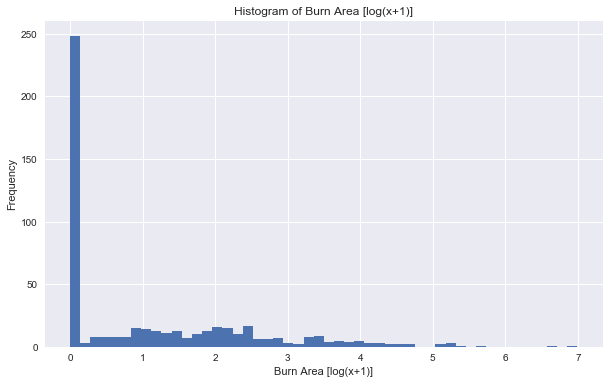

In [28]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(np.log(df.area + 1), bins=50)
plt.ylabel("Frequency")
plt.xlabel("Burn Area [log(x+1)]")
plt.title("Histogram of Burn Area [log(x+1)]")
plt.show()

The reason why I choise to do the analysis on this dataset is because this look svery similar to a [tweedie distribution](https://www.statisticshowto.datasciencecentral.com/tweedie-distribution/). Knowing this might help me to predict this varaible a little easier.

In any case, I will create a TODO to transform our variable when it is time for modeling.

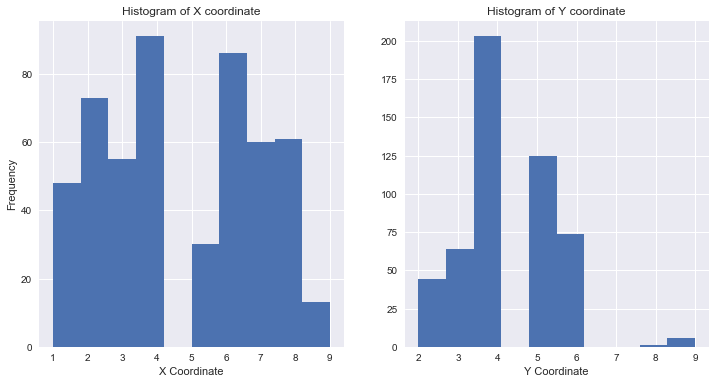

In [33]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='white', edgecolor='k')
plt.subplot(1, 2, 1)
plt.hist(df.X, bins=10)
plt.ylabel("Frequency")
plt.xlabel("X Coordinate")
plt.title("Histogram of X coordinate")
plt.subplot(1, 2, 2)
plt.hist(df.Y, bins=10)
plt.xlabel("Y Coordinate")
plt.title("Histogram of Y coordinate")
plt.show()

We can see for  for X and Y variables, that the most fires happen in the southern part of the map and not usually in the center. This might be because a small fire will be protected by some kind of wind until it is large enough to not be immediately put out by wind. Meanwhile, it also will have the most access to fuel. This is something that I investigate further in the bivariate analysis.

One thing to note is that the Y coordinates seem to be very tightly concentrated on a specific area, while the X coordinate is more spread out.

I guess that I shouldnt miss the obvious missing values at the 4,4 coordinate. This might be because there is only rock at this area or something.

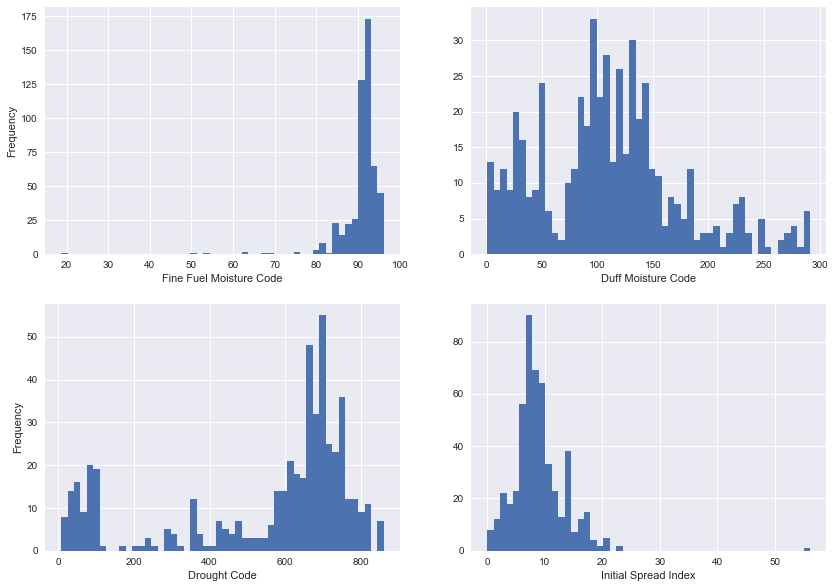

In [48]:
fig, ax = plt.subplots(figsize=(14,10), facecolor='white', edgecolor='k')
plt.subplot(2, 2, 1)
plt.hist(df.FFMC, bins=50)
plt.ylabel("Frequency")
plt.xlabel("Fine Fuel Moisture Code")
plt.subplot(2, 2, 2)
plt.hist(df.DMC, bins=50)
plt.xlabel("Duff Moisture Code")
plt.subplot(2, 2, 3)
plt.ylabel("Frequency")
plt.hist(df.DC, bins=50)
plt.xlabel("Drought Code")
plt.subplot(2, 2, 4)
plt.hist(df.ISI, bins=50)
plt.xlabel("Initial Spread Index")
plt.show()

We can already see that each of the FWI codes can span over very different ranges. 

There seems to be a many parts in this park that have plenty of fine-fuel, very few sections have less than 60% fine fuel. 

It's interesting to see that the Moisture and Drought codes look like a loose mirror-image of each other. This kind of makes sense because they both relate to the buildup index.

Finally, we can see the initial spread index looks a little like a poisson distribution, even if there is no frequency dimention for this kind of data. (i.e. x per y) Isntead, it is probably best to think of it as a log-normal distribution.

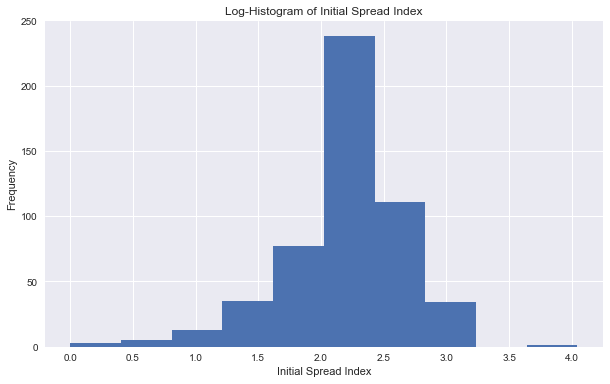

In [47]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='k')
plt.hist(np.log(df.ISI+1), bins=10)
plt.title("Log-Histogram of Initial Spread Index")
plt.xlabel("Initial Spread Index")
plt.ylabel("Frequency")
plt.show()

It seems that although it might have been an iteresting idea that the ISI was log-normal distributed, this doesn't really seem to be the case since it is still a little bit left-skewed. 

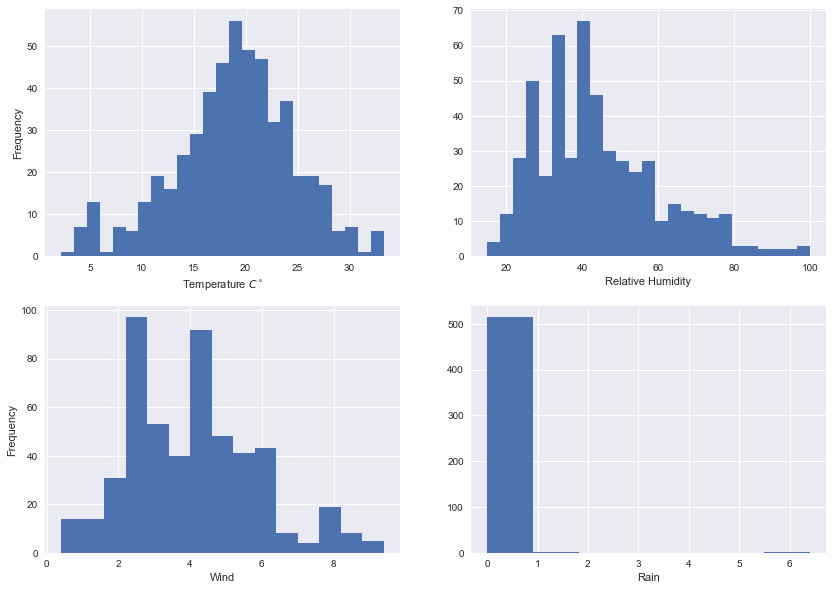

In [56]:
fig, ax = plt.subplots(figsize=(14,10), facecolor='white', edgecolor='k')
plt.subplot(2, 2, 1)
plt.hist(df.temp, bins=25)
plt.ylabel("Frequency")
plt.xlabel("Temperature $C^\circ$")
plt.subplot(2, 2, 2)
plt.hist(df.RH, bins=25)
plt.xlabel("Relative Humidity")
plt.subplot(2, 2, 3)
plt.ylabel("Frequency")
plt.hist(df.wind, bins=15)
plt.xlabel("Wind")
plt.subplot(2, 2, 4)
plt.hist(df.rain, bins=7)
plt.xlabel("Rain")
plt.show()

The most striking thing about this plot is how most days there is no rain. This would certainly help create forrest fires.

Temperature is nicely normally distributed though, which is fun to see.

Relative humidity is a little right skewed and wind varies quite a bit.

## EDA: Bivariate Analysis

Text.

In [ ]:
# TODO: Correlation plot

In [ ]:
# TODO: Map plot of X and Y coordinates

## EDA: Multivariate Analysis

Text.

In [ ]:
# TODO: Combine Map Plot of (X, Y) with flamability and area burned

## EDA: Summary

### Univariate

Text.

### Bivariate

Text.

### Multivariate

Text.

## Data Cleaning and Feature Engineering

Text.

In [ ]:
# TODO: Check for missing values

In [ ]:
# TODO: Split Data into X, y

In [ ]:
# TODO: Transform y into ln(y + 1)

In [ ]:
# TODO: Encode Day, Month into C-to-1

In [ ]:
# TODO: Normalise the rest of the variables on N(0, 1)

In [ ]:
# TODO: Convert X and y into matrices using numpy

## ML Models: SVM

Text.

In [ ]:
# TODO: Feature Selection

## ML Models: XGBoost

Text.

## ML Models: Discussion
Text.

## Conclusion
Text.